<a href="https://colab.research.google.com/github/nicolejimenezq95/Algorithms/blob/master/FruitsT1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# code for run on google colab
"""
!pip install git+https://github.com/Kaggle/kaggle-api.git --upgrade
import os
credentials = {"username":"kaggle_username","key":"Kaggle_API_keys"}
os.environ['KAGGLE_USERNAME']=credentials["username"]
os.environ['KAGGLE_KEY']=credentials["key"]
!kaggle datasets download -d moltean/fruits
!unzip fruits.zip
"""

'\n!pip install git+https://github.com/Kaggle/kaggle-api.git --upgrade\nimport os\ncredentials = {"username":"kaggle_username","key":"Kaggle_API_keys"}\nos.environ[\'KAGGLE_USERNAME\']=credentials["username"]\nos.environ[\'KAGGLE_KEY\']=credentials["key"]\n!kaggle datasets download -d moltean/fruits\n!unzip fruits.zip\n'

In [2]:
# Librairies

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Import dataset for Google Colab
"""
data_dir = '/content/fruits-360'
print('Folders :', os.listdir(data_dir))
classes = os.listdir(data_dir + "/Training")
print('131 classes :', classes)
"""

'\ndata_dir = \'/content/fruits-360\'\nprint(\'Folders :\', os.listdir(data_dir))\nclasses = os.listdir(data_dir + "/Training")\nprint(\'131 classes :\', classes)\n'

In [5]:
# re-sizing all the images
IMAGE_SIZE = [224, 224]

train_path = '/content/drive/MyDrive/fruits-360/Training'
valid_path = '/content/drive/MyDrive/fruits-360/Test'

In [6]:
# Import dataset for Kaggle. 

data_dir = '/content/drive/MyDrive/fruits-360'
print('Folders :', os.listdir(data_dir))
print("******************************************************************************")
classes = os.listdir(data_dir + "/Training")
print('131 classes :', classes)

Folders : ['readme.md', 'LICENSE', 'Training', 'Test', 'papers', 'test-multiple_fruits']
******************************************************************************
131 classes : ['Tomato Cherry Red', 'Walnut', 'Tomato Maroon', 'Tomato Heart', 'Tomato 4', 'Watermelon', 'Tomato not Ripened', 'Tomato Yellow', 'Strawberry Wedge', 'Tamarillo', 'Tangelo', 'Tomato 3', 'Strawberry', 'Salak', 'Tomato 2', 'Tomato 1', 'Redcurrant', 'Raspberry', 'Quince', 'Rambutan', 'Pomelo Sweetie', 'Pomegranate', 'Potato Red', 'Potato Sweet', 'Plum 3', 'Plum 2', 'Potato Red Washed', 'Potato White', 'Plum', 'Pitahaya Red', 'Pineapple Mini', 'Pineapple', 'Physalis', 'Physalis with Husk', 'Pepper Green', 'Pepino', 'Pear Red', 'Pear Williams', 'Pepper Orange', 'Pear Stone', 'Pepper Red', 'Pepper Yellow', 'Pear Kaiser', 'Pear Monster', 'Peach 2', 'Passion Fruit', 'Peach Flat', 'Pear Abate', 'Pear Forelle', 'Peach', 'Pear', 'Pear 2', 'Orange', 'Papaya', 'Mulberry', 'Onion White', 'Onion Red Peeled', 'Nut Pecan', 

In [8]:
dataset = ImageFolder(data_dir + '/Training', transform=ToTensor())
print('Size of training dataset :', len(dataset))
test = ImageFolder(data_dir + '/Test', transform=ToTensor())
print('Size of test dataset :', len(test))

Size of training dataset : 67702
Size of test dataset : 22688


In [9]:
# view one image shape of the dataset.
img, label = dataset[599]
print(img.shape)

torch.Size([3, 100, 100])


Label:  Apple Crimson Snow (1)


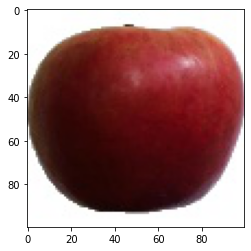

In [11]:
# function for the showing the image.
def show_image(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))
    
show_image(*dataset[599])

Label:  Grape White (46)


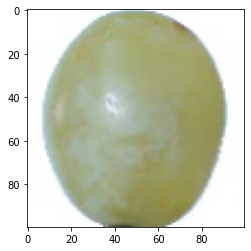

In [12]:
show_image(*dataset[23480])


In [13]:
torch.manual_seed(20)
val_size = len(dataset)//10
train_size = len(dataset) - val_size

In [14]:
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds) # train_ds length = dataset length - val_ds length

(60932, 6770)

In [15]:
batch_size = 64
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


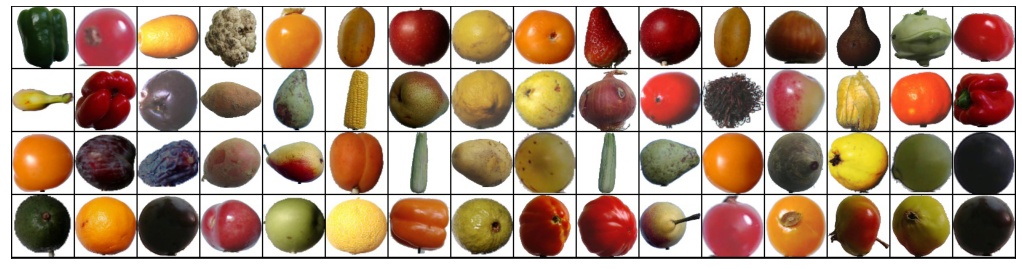

In [16]:
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

In [17]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [18]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [19]:
torch.cuda.is_available()


True

In [20]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [21]:
device = get_default_device()
device

device(type='cuda')

In [22]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

Training

In [23]:
input_size = 3*100*100
output_size = 131 # Number of classe

In [24]:
class Model(ImageClassificationBase):
    def __init__(self, input_size, output_size):
        super().__init__()
        # hidden layer
        self.in_layer = nn.Linear(input_size, 8384)
        self.hidden1 = nn.Linear(8384, 4192)
        self.hidden2 = nn.Linear(4192, 2096)
        self.hidden3 = nn.Linear(2096, 1048)
        self.out_layer = nn.Linear(1048, output_size)
        
    def forward(self, xb):
        # Flatten images into vectors
        out = xb.view(xb.size(0), -1)
        # Apply layers & activation functions
        # Input layer
        out = self.in_layer(out)
        # Hidden layers w/ ReLU
        out = self.hidden1(F.relu(out))
        out = self.hidden2(F.relu(out))
        out = self.hidden3(F.relu(out))
        # Class output layer
        out = self.out_layer(F.relu(out))
        return out

In [26]:
model = to_device(Model(input_size, output_size), device)


In [27]:
history = [evaluate(model, val_loader)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_acc': 0.007517688907682896, 'val_loss': 4.875579833984375}]

In [28]:
history += fit(7, 0.01, model, train_loader, val_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Epoch [0], train_loss: 4.2275, val_loss: 8.6650, val_acc: 0.0225



Epoch [1], train_loss: 2.1480, val_loss: 6.8819, val_acc: 0.1074



Epoch [2], train_loss: 1.1829, val_loss: 5.0821, val_acc: 0.2318



Epoch [3], train_loss: 0.6956, val_loss: 0.4405, val_acc: 0.8697



Epoch [4], train_loss: 0.4674, val_loss: 0.3433, val_acc: 0.8864



Epoch [5], train_loss: 0.3322, val_loss: 0.9730, val_acc: 0.8223



Epoch [6], train_loss: 0.2885, val_loss: 0.7245, val_acc: 0.8226


In [29]:
history += fit(8, 0.001, model, train_loader, val_loader)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Epoch [0], train_loss: 0.0846, val_loss: 0.0766, val_acc: 0.9828



Epoch [1], train_loss: 0.0656, val_loss: 0.0744, val_acc: 0.9802



Epoch [2], train_loss: 0.0594, val_loss: 0.0627, val_acc: 0.9891



Epoch [3], train_loss: 0.0549, val_loss: 0.0583, val_acc: 0.9883



Epoch [4], train_loss: 0.0514, val_loss: 0.0548, val_acc: 0.9895



Epoch [5], train_loss: 0.0484, val_loss: 0.0520, val_acc: 0.9902



Epoch [6], train_loss: 0.0457, val_loss: 0.0495, val_acc: 0.9891



Epoch [7], train_loss: 0.0434, val_loss: 0.0472, val_acc: 0.9910


In [30]:
history += fit(3, 0.0001, model, train_loader, val_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Epoch [0], train_loss: 0.0406, val_loss: 0.0454, val_acc: 0.9920



Epoch [1], train_loss: 0.0401, val_loss: 0.0452, val_acc: 0.9922



Epoch [2], train_loss: 0.0399, val_loss: 0.0450, val_acc: 0.9920


Evaluating the model

In [31]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.show()
    
    
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()

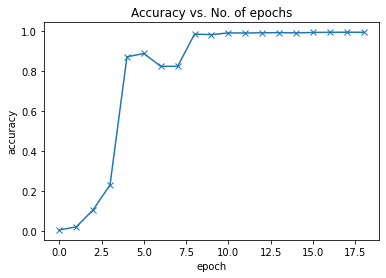

In [32]:
plot_accuracies(history)

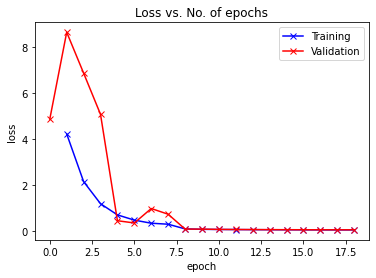

In [33]:
plot_losses(history)

In [34]:
evaluate(model, test_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'val_acc': 0.8977791666984558, 'val_loss': 0.42775335907936096}